# Flowers Taxonomic Classification

The goal of this study is to provide a deep learning algorithm that can perform a **taxonomic classification of flowers** based on the dataset capitalized by the Visual Geometry Group of the University of Oxford, consisting of 102 flower categories commonly occuring in the United Kingdom (Each class consists of between 40 and 258 images, further details and the complete dataset can be found here: http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

A few examples can be visualized below:

<img src='assets/flowers.png', width=500px>

This classification is challenged by some relevant difficulties:

* The images have large scale, pose and light variations;
* There are categories that have large variations within the category;
* There are several very similar categories. 

The project is broken down into multiple steps:

* Load and preprocess the image dataset;
* Train and test the image classifier thanks to the training, validation and testing datasets;
* Use the trained classifier to predict image content.

## Prerequisite

First, we have to import the different packages we will need:

In [1]:
# Needed packages imports:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch, time, json
from torch import nn, optim, onnx
from torchvision import datasets, transforms, models
from collections import OrderedDict
from workspace_utils import active_session
from PIL import Image

## First step: Load and preprocess the image dataset

Here we will use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise we can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz).

The dataset is split into three parts: training, validation, and testing.

For the training, we are going to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. We will also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this we don't want any scaling or rotation transformations, but we will need to resize then crop the images to the appropriate size.

The pre-trained networks we will use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets we will need so to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations, it's `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
# Shortcut variables to the training, validation and testing datasets:
data_dir = 'flowers'
training_dir = data_dir + '/train'
validation_dir = data_dir + '/valid'
testing_dir = data_dir + '/test'

In [3]:
# Transforms for the training, validation and testing datasets:

train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

validate_test_transforms = transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406],
                                                                  [0.229, 0.224, 0.225])])

# Load the training, validation and testing datasets with ImageFolder:
training_dataset = datasets.ImageFolder(training_dir, transform=train_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validate_test_transforms)
testing_dataset = datasets.ImageFolder(testing_dir, transform=validate_test_transforms)

# Using the image datasets and the trainforms, define the dataloaders:
trainingloader = torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True)
validationloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32)
testingloader = torch.utils.data.DataLoader(testing_dataset, batch_size=32)

### *Label mapping*

We will also need to load in a mapping from category label to category name. We can find this in the file `cat_to_name.json`. It's a JSON object which we can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give us a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
# Create a dictionary which maps from category labels to category names:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

To facilitate our future work, we will also create a dictionary to link indices to category labels.

In [5]:
# Create a dictionary which maps from indices to category labels:
idx_to_class = dict(zip(training_dataset.class_to_idx.values(),
                        training_dataset.class_to_idx.keys()))

## Second step: Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, we will use one of the pretrained models from `torchvision.models` to get the image features.

For this, we have to:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html);
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout;
* Train the classifier layers using backpropagation using the pre-trained network to get the features;
* Track the loss and accuracy on the validation set to determine the best hyperparameters.

In [6]:
# Choose a pretrained neural network:
model = models.densenet161(pretrained=True)

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.torch/models/densenet161-8d451a50.pth
100%|██████████| 115730790/115730790 [00:03<00:00, 32601904.55it/s]


In what follows, the different hyperparameters (number of hidden layers, number of hidden units, activation functions, dropout probabilities, learning rate...) characterizing the model to be built will have been frozen. In order to leave this notebook clear, I prefer not to show the different tests that led me to make these choices.

Nevertheless, it is always interesting to evaluate the influence of each of these hyperparameters (e.g. learning rate) over the epochs on the level of performance of the model built.

In [7]:
# Freeze the features but adapt the classifier:

for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([('input', nn.Linear(2208, 1054)),
                                        ('drop1', nn.Dropout(p=0.2)),
                                        ('act1', nn.ReLU()),
                                        ('hl1', nn.Linear(1054, 204)),
                                        ('drop2', nn.Dropout(p=0.2)),
                                        ('act2', nn.ReLU()),
                                        ('hl2', nn.Linear(204, 102)),
                                        ('output', nn.LogSoftmax(dim=1))]))

model.classifier = classifier

The error function used in the neural network is the cross entropy function, classically used in classification problems.

For the backpropagation phase, the optimization algorithm used is the Adam agorithm, which is an advantageous variant of stochastic gradient descent agorithm.

In [8]:
# Define criterion and optimizer:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In order to follow the process of building the model, we will create a performance file on which we will record the various metrics.

In [9]:
# Create a performance tracking file for the training session:
performance_file = open('training/densenet161-performances-EXAMPLE.txt', 'w')
performance_file.write("# Epoch, Training Loss, Training Accuracy, Validation Loss, Validation Accuracy\n")
performance_file.close()

Given the limitations of the environment, we will below expose the training process used, limiting the number of epochs to 3. It should be noted that the training is done in GPU mode.

In [10]:
# Training of the chosen pretrained neural network:

print("Training of the chosen pretrained neural network:\n")

start_time = time.time()
epochs = 3
model.to('cuda')

# Maintain the session active:
with active_session():

    for e in range(epochs):
        print("*** Epoch {}".format(e+1))

        # Forward and backward loop:
        model.train()
        running_loss = 0
        for data in trainingloader:
            inputs, labels = data
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Check loss and accuracy on the training dataset:
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in trainingloader:
                images, labels = data
                images, labels = images.to('cuda'), labels.to('cuda')
                outputs = model.forward(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print("Training: Loss... {:.2f},".format(running_loss),
              "Accuracy... {:.2f}%".format(100 * correct / total))

        performance_file = open('training/densenet161-performances-EXAMPLE.txt', 'a')
        performance_file.write("{} {:.2f} {:.2f}".format(e+1, running_loss, 100 * correct / total))

        # Check loss and accuracy on the validation dataset:
        model.eval()
        running_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in validationloader:
                images, labels = data
                images, labels = images.to('cuda'), labels.to('cuda')
                outputs = model.forward(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print("Validation: Loss... {:.2f},".format(running_loss),
              "Accuracy... {:.2f}%".format(100 * correct / total))

        performance_file.write(" {:.2f} {:.2f}\n".format(running_loss, 100 * correct / total))
        performance_file.close()

        # Model's checkpoint:
        checkpoint_index = str(e + 1)
        checkpoint_file = 'models/densenet161-checkpoint-' + checkpoint_index + '-EXAMPLE.pth'
        torch.save(model, checkpoint_file)

# Time performance:
end_time = time.time()
total_time = int(end_time - start_time)
hours = total_time // 3600
minutes = (total_time % 3600) // 60
seconds = (total_time % 3600) % 60

print("\nEnd of the tests... {:02d}h {:02d}m {:02d}s".format(hours, minutes, seconds))

Training of the chosen pretrained neural network:

*** Epoch 1
Training: Loss... 419.42, Accuracy... 13.23%
Validation: Loss... 104.96, Accuracy... 13.20%
*** Epoch 2
Training: Loss... 327.60, Accuracy... 38.83%
Validation: Loss... 80.39, Accuracy... 40.10%
*** Epoch 3
Training: Loss... 240.92, Accuracy... 51.68%
Validation: Loss... 58.48, Accuracy... 51.47%

End of the tests... 00h 17m 53s


After 100 epochs, we can visualize the results obtained.

In order to help us make our decision when choosing the best model, in addition to the standard loss and accuracy graphs, we have also plotted "relative error type" graphs on these two metrics, considering the sample results obtained over 100 epochs.

In [11]:
# Read the data contained in the performance file:

epoch_list = []
training_loss_list = []
training_accuracy_list = []
validation_loss_list = []
validation_accuracy_list = []

with open('training/densenet161-performances.txt', 'r') as performance_file:
    f_line = performance_file.readline()
    while f_line != "":
        if f_line[0] != "#":
            f_line_l = f_line.strip().split()
            epoch_list.append(int(f_line_l[0]))
            training_loss_list.append(float(f_line_l[1]))
            training_accuracy_list.append(float(f_line_l[2]))
            validation_loss_list.append(float(f_line_l[3]))
            validation_accuracy_list.append(float(f_line_l[4]))
        f_line = performance_file.readline()

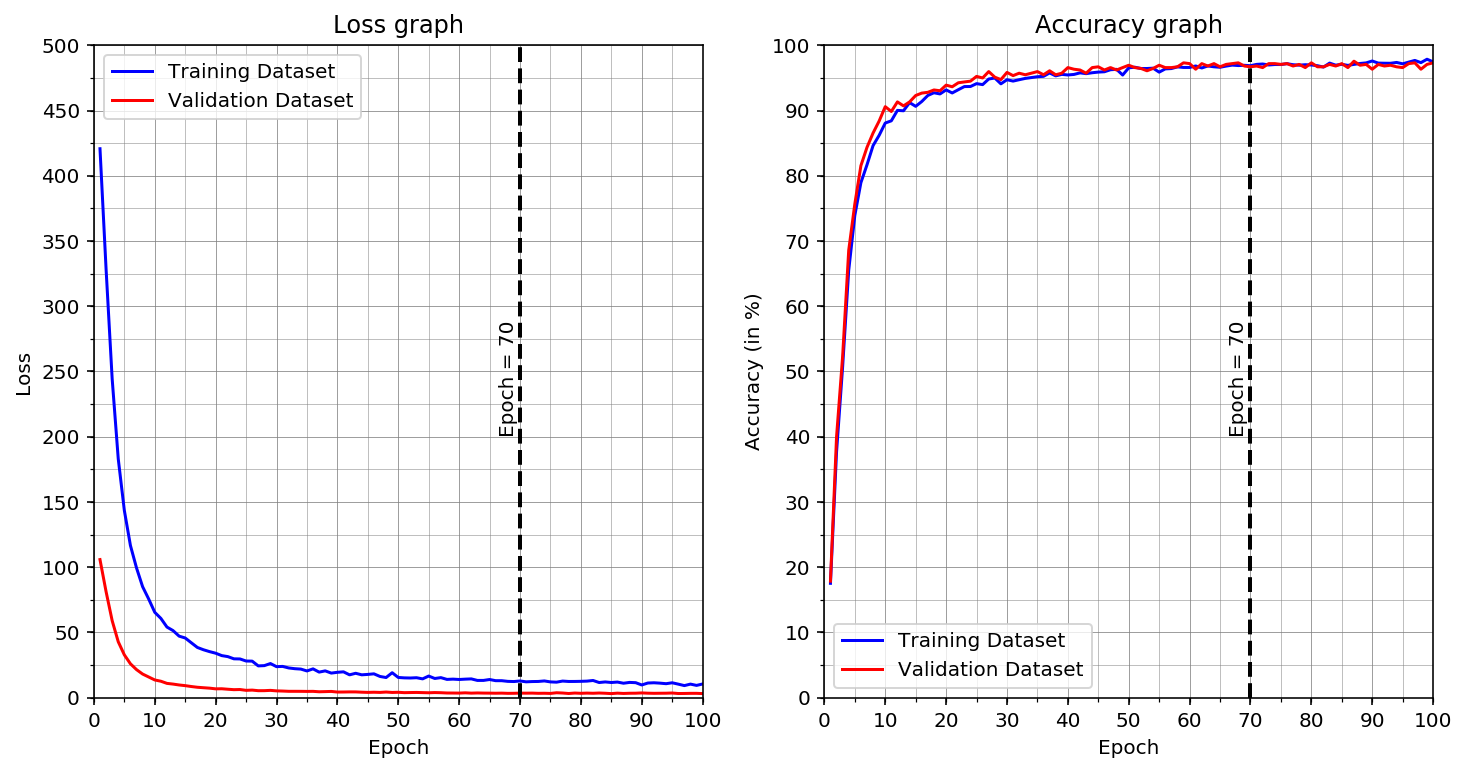

In [12]:
# Represent the loss and accuracy graphs to choose the best model:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Configuration of the loss graph:
axes[0].set_title('Loss graph')
axes[0].plot(epoch_list, training_loss_list, color='blue', linestyle='solid', label='Training Dataset')
axes[0].plot(epoch_list, validation_loss_list, color='red', linestyle='solid', label='Validation Dataset')
axes[0].plot([70, 70], [0, 500], color='black', linestyle='dashed', linewidth=2)
axes[0].set_xlim(0, 100)
axes[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[0].xaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(0, 500)
axes[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[0].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
axes[0].set_ylabel('Loss')
axes[0].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[0].text(69, 200, 'Epoch = 70', rotation=90, rotation_mode='anchor')
axes[0].legend(loc=2)

# Configuration of the accuracy graph:
axes[1].set_title('Accuracy graph')
axes[1].plot(epoch_list, training_accuracy_list, color='blue', linestyle='solid', label='Training Dataset')
axes[1].plot(epoch_list, validation_accuracy_list, color='red', linestyle='solid', label='Validation Dataset')
axes[1].plot([70, 70], [0, 100], color='black', linestyle='dashed', linewidth=2)
axes[1].set_xlim(0, 100)
axes[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[1].xaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[1].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(21))
axes[1].set_ylabel('Accuracy (in %)')
axes[1].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[1].text(69, 40, 'Epoch = 70', rotation=90, rotation_mode='anchor')
axes[1].legend(loc=3)

# Save the training graphs:
fig.savefig('graphs/densenet161-training-graphs.png')

In [13]:
# Relative error on loss on the training dataset:
re_training_loss_list = []
for i in range(100):
    relative_error = abs((training_loss_list[i] - min(training_loss_list))/min(training_loss_list))
    re_training_loss_list.append(relative_error)
    
# Relative error on accuracy on the training dataset:
re_training_accuracy_list = []
for i in range(100):
    relative_error = abs((training_accuracy_list[i] - max(training_accuracy_list))/max(training_accuracy_list))
    re_training_accuracy_list.append(relative_error)
    
# Relative error on loss on the validation dataset:
re_validation_loss_list = []
for i in range(100):
    relative_error = abs((validation_loss_list[i] - min(validation_loss_list))/min(validation_loss_list))
    re_validation_loss_list.append(relative_error)
    
# Relative error on accuracy on the validation dataset:
re_validation_accuracy_list = []
for i in range(100):
    relative_error = abs((validation_accuracy_list[i] - max(validation_accuracy_list))/max(validation_accuracy_list))
    re_validation_accuracy_list.append(relative_error)

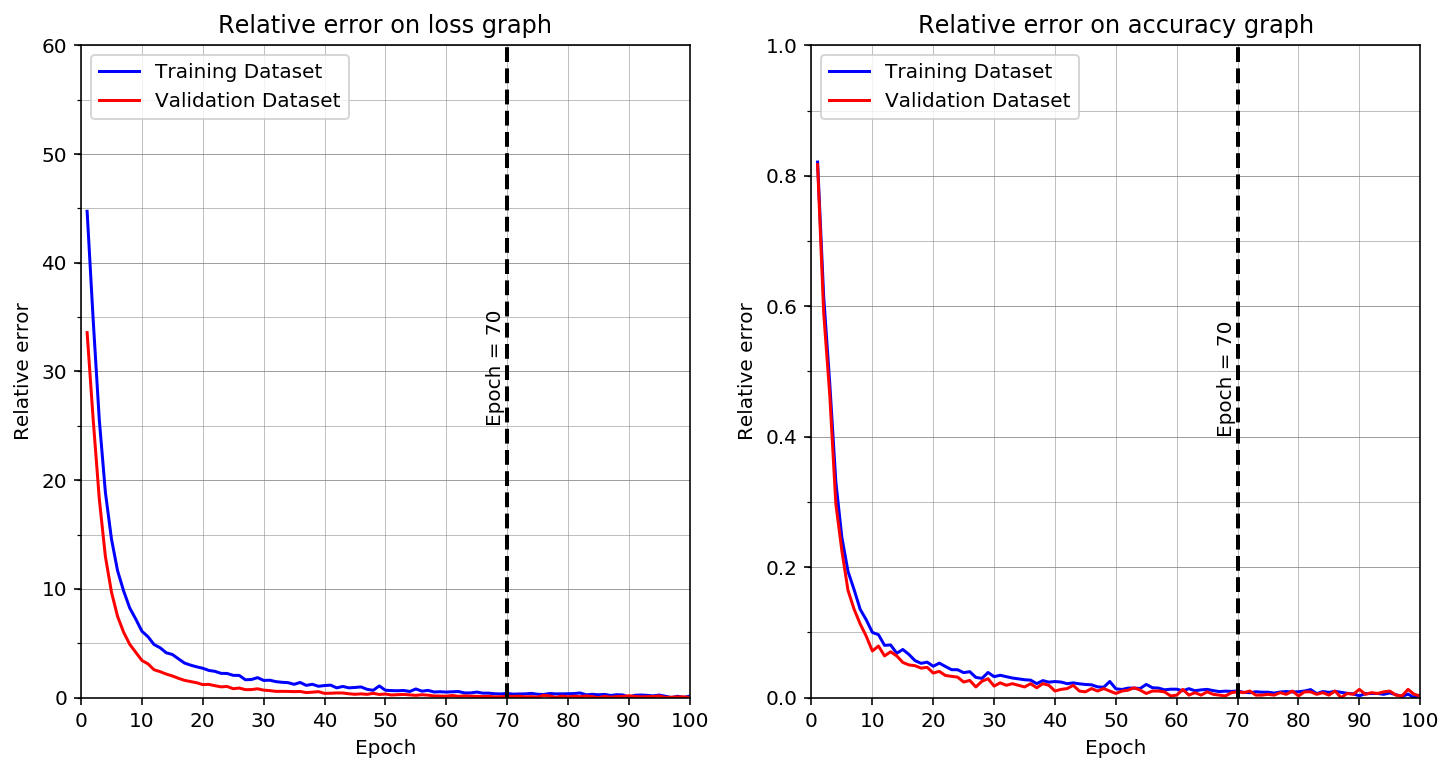

In [14]:
# Represent the relative error on loss and accuracy graphs to choose the best model:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Configuration of the relative error on loss graph:
axes[0].set_title('Relative error on loss graph')
axes[0].plot(epoch_list, re_training_loss_list, color='blue', linestyle='solid', label='Training Dataset')
axes[0].plot(epoch_list, re_validation_loss_list, color='red', linestyle='solid', label='Validation Dataset')
axes[0].plot([70, 70], [0, 60], color='black', linestyle='dashed', linewidth=2)
axes[0].set_xlim(0, 100)
axes[0].xaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[0].set_xlabel('Epoch')
axes[0].set_ylim(0, 60)
axes[0].yaxis.set_major_locator(mpl.ticker.MaxNLocator(7))
axes[0].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(13))
axes[0].set_ylabel('Relative error')
axes[0].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[0].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[0].text(69, 25, 'Epoch = 70', rotation=90, rotation_mode='anchor')
axes[0].legend(loc=2)

# Configuration of the relative error on accuracy graph:
axes[1].set_title('Relative error on accuracy graph')
axes[1].plot(epoch_list, re_training_accuracy_list, color='blue', linestyle='solid', label='Training Dataset')
axes[1].plot(epoch_list, re_validation_accuracy_list, color='red', linestyle='solid', label='Validation Dataset')
axes[1].plot([70, 70], [0, 1], color='black', linestyle='dashed', linewidth=2)
axes[1].set_xlim(0, 100)
axes[1].xaxis.set_major_locator(mpl.ticker.MaxNLocator(11))
axes[1].set_xlabel('Epoch')
axes[1].set_ylim(0, 1)
axes[1].yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
axes[1].yaxis.set_minor_locator(mpl.ticker.MaxNLocator(11))
axes[1].set_ylabel('Relative error')
axes[1].grid(color="grey", which="major", axis='x', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="major", axis='y', linestyle='solid', linewidth=0.25)
axes[1].grid(color="grey", which="minor", axis='y', linestyle='solid', linewidth=0.25)
axes[1].text(69, 0.4, 'Epoch = 70', rotation=90, rotation_mode='anchor')
axes[1].legend(loc=2)

# Save the relative error graphs:
fig.savefig('graphs/densenet161-relative-error-graphs.png')

On graphs representing loss and accuracy, after 100 epochs, the phenomenon of overfitting of the model to the training dataset does not appear clearly, although one can observe a stagnation of the quality of the model under of these two metrics (from approximately 10 epochs). By also relying on "relative error type" graphs, the (arbitrary) choice of the model generated after 70 epochs may appear as a reasonable and efficient choice.

### *A brief comment about the learning rate*

As Yoshua Bengio (http://www.iro.umontreal.ca/~bengioy/yoshua_en/index.html) said, the learning rate is the single most important hyperparameter, and one should always make sure it has been tuned.

A good starting point is 0.01, and other good options to consider are 0.1, 0.001, 0.0001 or 0.00001.

Here can be found various results that have been obtained during the experiments:

<img src='graphs/densenet161-learning-rate.png'>

Some comments:

* 0.1 is clearly not a good choice for the learning rate, on both loss and accuracy graphs, no amelioration can be observed over the epochs;
* 0.00001 is not a truly bad choice, on both loss and accuracy graphs, ameliorations can be observed over the epochs, nevertheless, these ameliorations are too slow to make 0.00001 a good choice for the learning rate;
* More or less the same can be said about the choice 0.01 for the learning rate, the results are furthermore better, nevertheless, a stagnation of the results obtained can be observed, which makes 0.01 not a good choice too for the learning rate
* 0.001 and 0.0001 appear as interesting choices for the learning rate, with good loss and accuracy results for both, the results are actually better for 0.001, but the tendancy is better for 0.0001, which is why we have chosen 0.0001 as our learning rate for the study.

*Nota Bene:* In this study, we have chosen a fixed learning rate, but we could have chosen a variable learning rate based on techniques such as learning rate decay or adaptive learning.

### *Loading the checkpoint*

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way we can come back to this project and keep working on it without having to retrain the network.

In [15]:
# Load the best model obtained:
model = torch.load('models/best-model_CUDA.pth')

*Nota Bene:* If we decide to work in CPU mode, we should load 'best-model_CPU.pth'.

### *Testing our network*

It's good practice to test our trained network on test data, images the network has never seen either in training or validation. This will give us a good estimate for the model's performance on completely new images.

Here we are going to run the test images through the network and measure the loss and accuracy the same way we did for validation.

We should be able to reach the same results we obtained on the validation dataset if the model has been trained well.

In [16]:
# Test the best model obtained on the testing dataset:

print("Test of the best model obtained on the testing dataset:")

model.eval()
running_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for data in testingloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Loss... {:.2f},".format(running_loss),
      "Accuracy... {:.2f}%".format(100 * correct / total))

Test of the best model obtained on the testing dataset:
Loss... 2.88, Accuracy... 97.56%


Here we have obtained an accuracy of **97.56%** on the testing dataset, which a very good result!

### *Save the checkpoint*

Now that our network is trained, we are going to save the model so we can load it later for making predictions.

We also want to save other things such as the mapping of classes to indices which we get from one of the image datasets: `image_datasets['train'].class_to_idx`. We can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that we will want to completely rebuild the model later so we can use it for inference: We are going to make sure to include any information we need in the checkpoint (number of epochs, the optimizer state `optimizer.state_dict`...).

In [17]:
# Save the best model with the recommanded approach:

model = torch.load('models/best-model_CPU.pth')

checkpoint = {'state_dict': model.state_dict(),
              'idx_to_class': idx_to_class}

torch.save(checkpoint, 'models/rebuilt-model_CPU.pth')

Now, let's write a function that loads this checkpoint and rebuild the corresponding model.

In [18]:
def load_checkpoint(model_file):
    ''' Rebuild model from checkpoint
    '''
    
    # Load checkpoint from model file:
    checkpoint = torch.load(model_file)
    
    # Rebuild the model:
    model = models.densenet161()
    model.classifier = nn.Sequential(OrderedDict([('input', nn.Linear(2208, 1054)),
                                                  ('drop1', nn.Dropout(p=0.2)),
                                                  ('act1', nn.ReLU()),
                                                  ('hl1', nn.Linear(1054, 204)),
                                                  ('drop2', nn.Dropout(p=0.2)),
                                                  ('act2', nn.ReLU()),
                                                  ('hl2', nn.Linear(204, 102)),
                                                  ('output', nn.LogSoftmax(dim=1))]))
    model.load_state_dict(checkpoint['state_dict'])
    
    # Add the dictionary to link indices to category labels:
    model.idx_to_class = checkpoint['idx_to_class']
    
    return model

We can now rebuild the best model and fast check that the processing has been correctly done.

In [19]:
# Rebuild the best model from checkpoint:
rebuilt_model = load_checkpoint('models/rebuilt-model_CPU.pth')

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [20]:
# Fast check of the rebuilt model:

print("Fast check of the rebuilt model (results on the testing dataset):")

if torch.cuda.is_available():
    rebuilt_model.to('cuda')
rebuilt_model.eval()

criterion = nn.NLLLoss()
running_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for data in testingloader:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.to('cuda'), labels.to('cuda')
        outputs = rebuilt_model.forward(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print("Loss... {:.2f},".format(running_loss),
      "Accuracy... {:.2f}%".format(100 * correct / total))

Fast check of the rebuilt model (results on the testing dataset):
Loss... 2.88, Accuracy... 97.56%


The fast checking performed is OK.

## Third step: Inference for classification

Now we will write a function to use a trained network for inference. That is, we will pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First we will need to handle processing the input image such that it can be used in your network. 

### *Image Preprocessing*

We want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, we are going to resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then we will need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1: We will need to convert the values. It's easiest with a Numpy array, which we can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations, it's `[0.229, 0.224, 0.225]`: We need to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array: We can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [21]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Open the image corresponding to the given path:
    im = Image.open(image)

    # Resize the image where the shortest side is 256 pixels, keeping the aspect ratio:
    im_width, im_height = im.size
    im_ratio = im_height/im_width
    if im_width <= im_height:
        im_s1_width = 256
        im_s1_height = int(im_s1_width*im_ratio)
        im_s1_size = im_s1_width, im_s1_height
        im_s1 = im.resize(im_s1_size)
    else:
        im_s1_height = 256
        im_s1_width = int(im_s1_height/im_ratio)
        im_s1_size = im_s1_width, im_s1_height
        im_s1 = im.resize(im_s1_size)

    # Crop out the center 224x224 portion of the image:
    im_s2_left = (im_s1_width - 224)//2
    im_s2_top = (im_s1_height - 224)//2
    im_s2_width = 224
    im_s2_height = 224
    im_s2_box = (im_s2_left,
                im_s2_top,
                im_s2_left + im_s2_width,
                im_s2_top + im_s2_height)
    im_s2 = im_s1.crop(im_s2_box)

    # Modify color channels encoding:
    im_s2_array_0 = np.array(im_s2)/255

    # Normalize color channels encoding:
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_s2_array_1 = (im_s2_array_0 - mean)/std

    # Adapt color channels encoding to PyTorch specifications:
    im_array = im_s2_array_1.transpose((2, 0, 1))

    return im_array

To check our work, the function below converts a PyTorch tensor and displays it in the notebook. If our `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [22]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

We can now test our work.

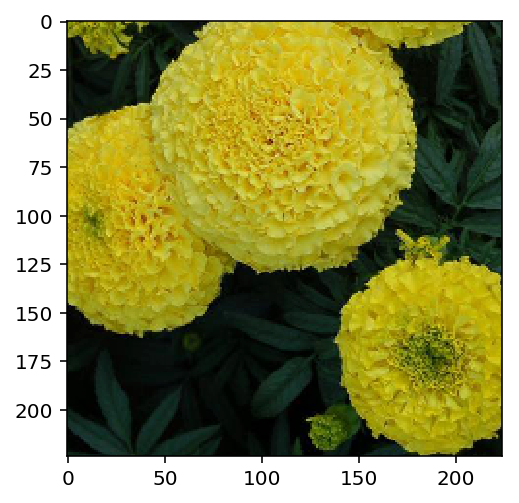

In [23]:
# Test on the image 'marigold.jpg':
processed_image = process_image('inputs/marigold.jpg')
imshow(processed_image)

### *Class Prediction*

Once we can get images in the correct format, it's time to write a function for making predictions with our model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. We want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. We need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` we used to load the data ([see here](#Save-the-checkpoint)). We have to make sure to invert the dictionary so we get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [24]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''

    # Make sure the model matches the device:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Preprocessing of the image:
    image_array = process_image(image_path)

    # Image classification by the trained model:
    model.eval()
    image_tensor = torch.FloatTensor(image_array)
    image_tensor.unsqueeze_(0)
    image_tensor = image_tensor.to(device)
    image_result = model.forward(image_tensor)

    # Get the top 5 most probable classes:
    probs_tensor, classes_tensor = image_result.topk(topk)
    if torch.cuda.is_available():
        # NumPy doesn't support CUDA:
        probs_tensor = probs_tensor.to('cpu')
    probs_array = probs_tensor.detach().numpy()
    probs = np.exp(probs_array[0])
    if torch.cuda.is_available():
        # NumPy doesn't support CUDA:
        classes_tensor = classes_tensor.to('cpu')
    classes_array = classes_tensor.detach().numpy()
    classes_idx = classes_array[0]
    classes = []
    for idx in classes_idx:
        classes.append(idx_to_class[idx])

    return probs, classes

We can now continue and test the function.

In [25]:
# Test on the image 'marigold.jpg':
probs, classes = predict('inputs/marigold.jpg', model)
print(probs)
print(classes)

[  9.96483326e-01   2.28501926e-03   3.69299174e-04   3.42351879e-04
   1.61417120e-04]
['47', '50', '54', '31', '27']


### *Sanity Checking*

Now that we can use a trained model for predictions, we are going to check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs.

We are going to use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png', width=300px>

We can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (it should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, we can equally use the `imshow` function defined above.

We are going to perform sanity checking on three images:
* 'balloon_flower.jpg'
* 'marigold.jpg'
* 'pink_primrose.jpg'

In [26]:
def preprocessing(image_path, model):
    ''' Preprocessing before ploting the results.
    '''

    # Generation of the probabilities and the flower names corresponding to the image:
    probs, classes = predict(image_path, model)
    names = []
    for cat in classes:
        names.append(cat_to_name[cat])
    names.reverse()
    probs = probs.tolist()
    probs.reverse()

    # Generation of the image to show:
    processed_image = process_image(image_path)
    processed_image = processed_image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    processed_image = std * processed_image + mean
    processed_image = np.clip(processed_image, 0, 1)

    return names, probs, processed_image

In [27]:
# Generate three prediction examples to plot:
names_1, probs_1, processed_image_1 = preprocessing('inputs/balloon_flower.jpg', model)
names_2, probs_2, processed_image_2 = preprocessing('inputs/marigold.jpg', model)
names_3, probs_3, processed_image_3 = preprocessing('inputs/pink_primrose.jpg', model)

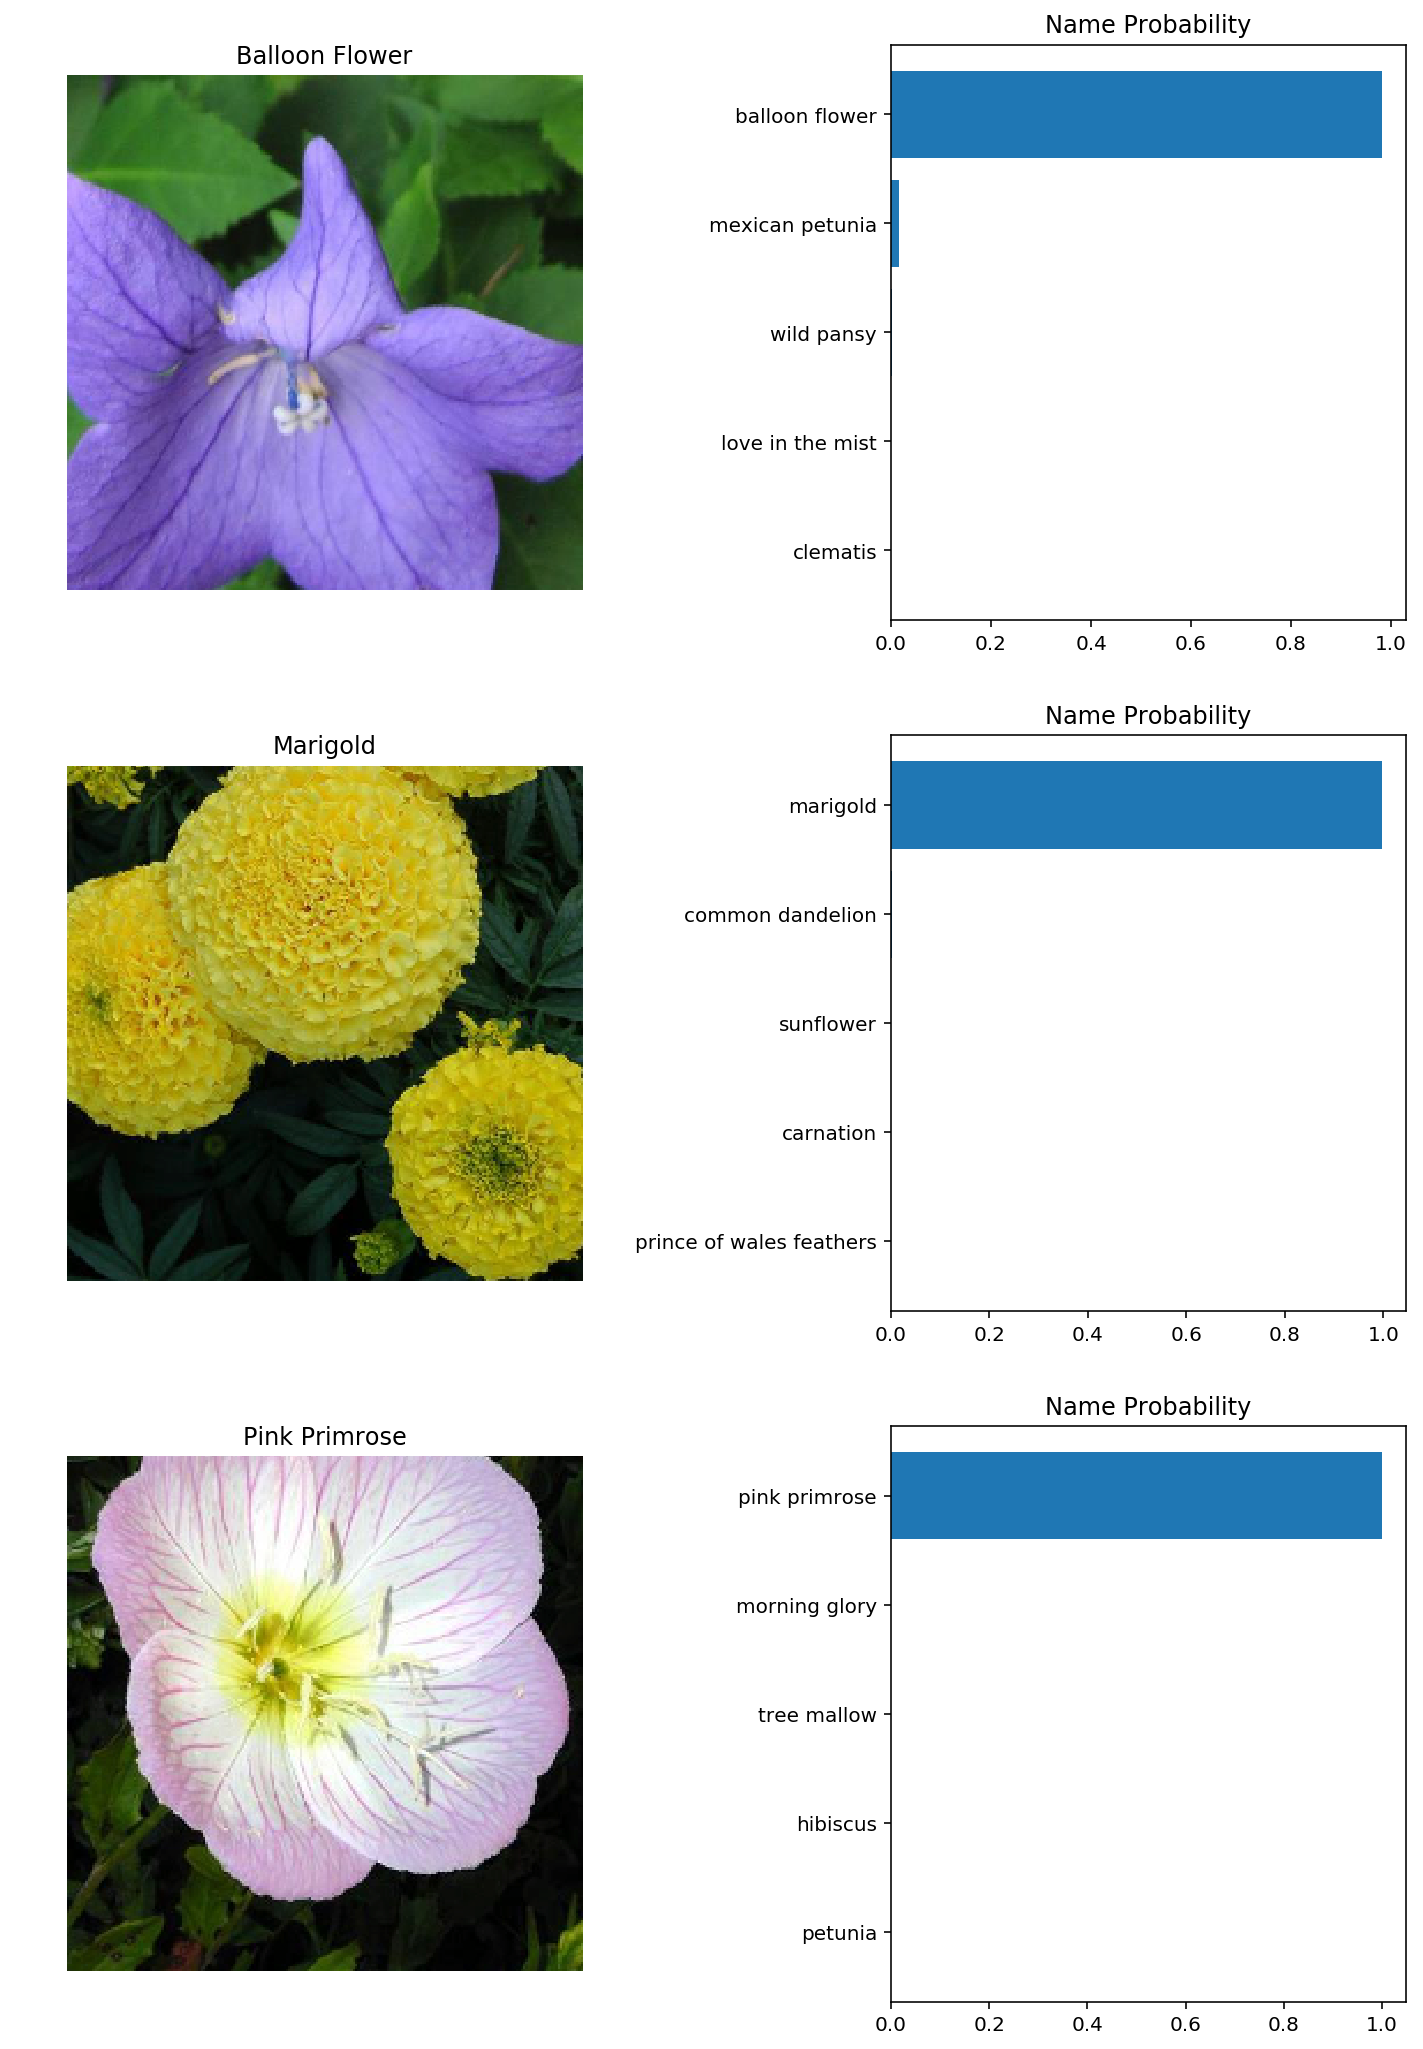

In [28]:
# Plot the three examples exposed above:
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
plt.subplots_adjust(wspace=0.6)

# First example:
axes[0, 0].set_title('Balloon Flower')
axes[0, 0].axis('off')
axes[0, 0].imshow(processed_image_1)
axes[0, 1].set_title('Name Probability')
axes[0, 1].barh(np.arange(5), probs_1)
axes[0, 1].set_yticks(np.arange(5))
axes[0, 1].set_yticklabels(names_1)

# Second example:
axes[1, 0].set_title('Marigold')
axes[1, 0].axis('off')
axes[1, 0].imshow(processed_image_2)
axes[1, 1].set_title('Name Probability')
axes[1, 1].barh(np.arange(5), probs_2)
axes[1, 1].set_yticks(np.arange(5))
axes[1, 1].set_yticklabels(names_2)

# Third example:
axes[2, 0].set_title('Pink Primrose')
axes[2, 0].axis('off')
axes[2, 0].imshow(processed_image_3)
axes[2, 1].set_title('Name Probability')
axes[2, 1].barh(np.arange(5), probs_3)
axes[2, 1].set_yticks(np.arange(5))
axes[2, 1].set_yticklabels(names_3)

# Save the prediction plots:
fig.savefig('outputs/prediction-plots.png')

## Appendix: ONNX

**ONNX** (**O**pen **N**eural **N**etwork E**X**change Format) is the new open ecosystem for interchangeable deep learning models, developed and supported by a community of partners (AWS, Facebook Open Source, Microsoft, Nvidia, IBM, Baidu...).

Thus, ONNX enables models to be trained in one framework and transferred to another for inference.

Currently, ONNX models are supported in Caffe2, Microsoft Cognitive Toolkit, MXNet, and PyTorch, and there are connectors for many other common frameworks and libraries.

An interested reader will find more information here: https://onnx.ai.

The ONNX exporter is a part of PyTorch (but we can note that PyTorch does not currently have support for importing ONNX models), and we are going to use this functionality.

We can imagine exporting the model trained here and then import it on Caffe2 (https://caffe2.ai) to run it on mobile devices, leveraging the cross-platform capability of Caffe2.

*Nota Bene:* The keyword argument `verbose=True` causes the exporter to print out a human-readable representation of the network, element we can use to check the validity of the resulting model or inspect the details.

In [29]:
# Load the best model obtained:
model = torch.load('models/best-model_CPU.pth')

# Standard ImageNet input - 3 channels, 224x224, values don't matter as we care about network structure:
dummy_input = torch.randn(1, 3, 224, 224)

# Export the best model obtained:
onnx.export(model, dummy_input, 'models/best-model_CPU.onnx', verbose=True)

graph(%0 : Float(1, 3, 224, 224)
      %1 : Float(96, 3, 7, 7)
      %2 : Float(96)
      %3 : Float(96)
      %4 : Float(96)
      %5 : Float(96)
      %6 : Float(96)
      %7 : Float(96)
      %8 : Float(96)
      %9 : Float(96)
      %10 : Float(192, 96, 1, 1)
      %11 : Float(192)
      %12 : Float(192)
      %13 : Float(192)
      %14 : Float(192)
      %15 : Float(48, 192, 3, 3)
      %16 : Float(144)
      %17 : Float(144)
      %18 : Float(144)
      %19 : Float(144)
      %20 : Float(192, 144, 1, 1)
      %21 : Float(192)
      %22 : Float(192)
      %23 : Float(192)
      %24 : Float(192)
      %25 : Float(48, 192, 3, 3)
      %26 : Float(192)
      %27 : Float(192)
      %28 : Float(192)
      %29 : Float(192)
      %30 : Float(192, 192, 1, 1)
      %31 : Float(192)
      %32 : Float(192)
      %33 : Float(192)
      %34 : Float(192)
      %35 : Float(48, 192, 3, 3)
      %36 : Float(240)
      %37 : Float(240)
      %38 : Float(240)
      %39 : Float(240)
      %40 : Float